
# Rank Regression
[![Slides](https://img.shields.io/badge/🦌-ReHLine-blueviolet)](https://rehline-python.readthedocs.io/en/latest/)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/17X81EsmYRYMcdLjlxasGTs9uUuGqyuiy?usp=sharing)

Suppose we have a dataset $\{(y_i,\mathbf{x}_j)\}_{i=1}^n$, where $y_i \in \mathbb{R}$ is the response and $\mathbf{x_i} \in \mathbb{R}^{d}$ is the independent variable. Assume the data is generated from the following linear regression model,

$$
 y_i = \boldsymbol{\beta}^{\intercal}\mathbf{x}_i + \epsilon_i, \quad i=1,2,\cdots n,
$$
where $\boldsymbol{\beta} \in \mathbb{R}^d$ is the unknown parameter to be estimated and $\{\epsilon_i\}_{i=1}^n$ are iid random errors.  

When the random errors $\{\epsilon_i\}_{i=1}^n$ follow non-Gaussian distributions, particularly those with heavy tails, the performance of OLS maybe poor. Rank regression is one of the robust regression methods which can deal with the case. It suffices to solve the following optimization problem (Jaeckel, 1972):

$$
  \min_{\boldsymbol{\beta} \in \mathbb{R}^d} \sum\limits_{i=1}^{n}R_i^c(\boldsymbol{\beta})(y_i - \boldsymbol{\beta}^{\intercal}\mathbf{x}_i),
$$
where $R_i^c(\boldsymbol{\beta})=R_i(\boldsymbol{\beta}) - \frac{n+1}{2}$, $R_i(\boldsymbol{\beta})$ is the rank of ${y_i-\boldsymbol{\beta}^{\intercal}\mathbf{x}_i}$ among all $\{ y_i-\boldsymbol{\beta}^{\intercal}\mathbf{x}_i\}_{i=1}^n$. Canonically, we estimate $\boldsymbol{\beta}$ by solving the following optimization problem,


$$
  \min_{\boldsymbol{\beta} \in \mathbb{R}^d} \frac{2}{n(n-1)}\sum\limits_{1 \leq i < j \leq n} \big| y_{ij} - \boldsymbol{\beta}^{\intercal} \mathbf{x}_{ij} \big| \tag{1}
$$
where $\mathbf{x}_{ij} = \mathbf{x}_i - \mathbf{x}_j$, $y_{ij}= y_i - y_j$. In the remaining part, I will show two methods to solve $(1)$ with implementations by rehline.

**Least absolute deviation (LAD)**  
By taking $\mathbf{x}_{ij}$ and $y_{ij}$ as observasions, problem $(1)$ can be regarded as a LAD problem. We can solve the LAD problem by rehline. The composite ReLU-ReHU parameters for LAD can be found in Table 2 of (Dai and Qiu, 2024).

**Quantile regression (QR)**  
Let $e_{ij}=y_{ij} - \boldsymbol{\beta}^{\intercal} \mathbf{x}_{ij}$. $(1)$ is equivalent to

$$
  \min_{\boldsymbol{\beta} \in \mathbb{R}^d} \frac{2}{n(n-1)} \sum\limits_{1 \leq i < j \leq n }  ( e_{ij} \mathbb{1}_{ \lbrace e_{ij} \geq 0 \rbrace} - e_{ij} \mathbb{1}_{ \lbrace e_{ij} < 0 \rbrace}   )  \tag{2}
$$

We compare $(2)$ with the check loss for quantile regression $\rho_{\tau}(ϵ)=ϵ(τ-\mathbb{1}_{\lbrace ϵ < 0 \rbrace}) = \tau ϵ \mathbb{1}_{ \lbrace \epsilon \geq 0 \rbrace } +(\tau-1)ϵ\mathbb{1}_{ \lbrace ϵ < 0 \rbrace}$. When $\tau=0.5$, solving $(2)$ is eqivalent to solving Quantile Regression by taking $\mathbf{x}_{ij}$ and $y_{ij}$ as observasions.

$$
  \min_{\boldsymbol{\beta} \in \mathbb{R}^d} \frac{4}{n(n-1)} \sum\limits_{1 \leq i < j \leq n }  \rho_{0.5}(y_{ij}-\boldsymbol{\beta}^{\intercal}\mathbf{x}_{ij})  \tag{3}
$$

## Numerical example

### Preparation  
**Generate the data**

In [2]:
from rehline import ReHLine, plqERM_Ridge
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, QuantileRegressor
import numpy as np
# Generate the data
n, d = 100, 4
X = np.random.randn(n, d)
beta_true = np.random.randn(d)
y = X.dot(beta_true) + np.random.standard_t(df=3, size=n)

**Differencing**

In [3]:
# Differencing
i, j = np.triu_indices(n, k=1)
X_diff = (X[:, np.newaxis, :] - X[np.newaxis, :, :])[i,j]
y_diff = (y[:, np.newaxis] - y[np.newaxis, :])[i,j]
n_diff = y_diff.shape[0]

### Solve the optimization problem by quantitle regression (QR)

Since `rehline.plqERM_Ridge` support for check loss, we can directly use it to solve the problem.



In [4]:
# solve the problem use quantitle regression model with $\tau = 0.5$ by reline
C = 4
quantile_regr = plqERM_Ridge(loss={'name': 'QR', 'qt': np.array([0.5])}, C=C, max_iter=10000)
quantile_regr.fit(X_diff, y_diff)
quantile_regr.coef_

array([-0.68189333, -0.57733262, -2.21493922, -0.19351859])

### Solve the optimization problem by least absolute deviation model (LAD)
Since the LAD loss is a plq function, we can also use `rehline.RehLine` to solve it by manually specifying the ReLU-ReHU parameters.

As shown in table 2 of (Dai and Qiu, 2024), when $L_i = C_i \big| y_i - \boldsymbol{\beta}^{\intercal} \mathbf{x}_i \big|$, ReLU parameters are as followed: $u_{1i}=C_i$, $v_{1i}=-C_i y_i$, $u_{2i}=-C_i$, $v_{2i}=C_i y_i$.

In [5]:
# solve the problem use the least absolute deviation model (LAD)
C = 2
U = np.zeros(shape=(2,n_diff))
V = np.zeros(shape=(2,n_diff))
U[0,:], U[1,:] = C, -C
V[0,:], V[1,:] = -C * y_diff, C * y_diff
lad_regr = ReHLine(C=C, max_iter=10000)
lad_regr.U, lad_regr.V = U,V
lad_regr.fit(X_diff)
lad_regr.coef_

array([-0.68189333, -0.57733262, -2.21493922, -0.19351859])

### Results

We compare the results of rank regression with OLS methods.

In [6]:
ols = LinearRegression(fit_intercept=False)
ols.fit(X, y)
ols.coef_

array([-0.66144318, -0.63704375, -2.25059478, -0.20229943])

In [7]:
from sklearn.metrics import r2_score
y_ols = ols.predict(X)
r2_score(y, y_ols)

0.681636901985671

In [8]:
y_rank = X.dot(quantile_regr.coef_)
r2_score(y, y_rank)

0.680993625742062

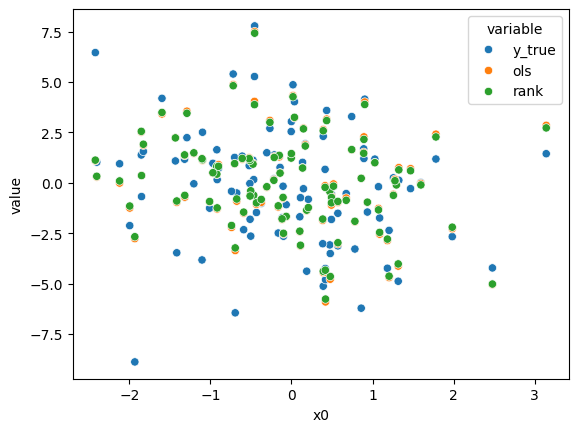

In [9]:
## plot QR results
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({'x0': X[:,0], 'y_true': y, 'ols': y_ols, 'rank': y_rank})
df = df.melt(id_vars='x0')

sns.scatterplot(data=df, x='x0', y='value', hue='variable')
plt.show()

## References
[1] Jaeckel, L. A. (1972). Estimating regression coefficients by minimizing the dispersion of the residuals. _The Annals of Mathematical Statistics_, 1449-1458.  
[2]  Dai, B., & Qiu, Y. (2024). ReHLine: regularized composite ReLU-ReHU loss minimization with linear computation and linear convergence. _Advances in Neural Information Processing Systems_, 36.